In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helpers.dataloader_v1 import *
import pickle
import os
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from inceptionResnet_v2 import *
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
import matplotlib.patches as patches
import skimage

In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
torch.cuda.device_count()

1

In [3]:
root_dir = '/scratch/bva212/breastCancerData'
image_column = 'image file path'
roi_column = 'ROI mask file path'
batchSize =1
num_classes = 4
image_resize =1024

train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([image_resize,image_resize]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([image_resize,image_resize]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

roi_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([image_resize,image_resize]),
        transforms.ToTensor()])


# randomTrainSet, randomValidationSet randomTestSet
train_data = CBISDDSMDataset('Train.pkl', root_dir, image_column, roi_column, num_classes = num_classes, roi_transform = roi_transform, num_channel=3, transform = train_transform, transform_type = None, transform_prob=0.5)
val_data = CBISDDSMDataset('Val.pkl', root_dir, image_column, roi_column, num_classes = num_classes, roi_transform=roi_transform, num_channel=3, transform = validation_transform, transform_type = None, transform_prob=0.5)
test_data = CBISDDSMDataset('Test.pkl', root_dir, image_column, roi_column, num_classes = num_classes,roi_transform=roi_transform, num_channel=3, transform = validation_transform, transform_type = None, transform_prob=0.5)

image_datasets = {'train': train_data, 'val': val_data, 'test': test_data}

# dataloaders = {x: DataLoader(image_datasets[x], batch_size=batchSize, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

def my_collate(batch):
    batch = list(filter(lambda x : x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)
 
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batchSize,
                        shuffle=True, num_workers=0, collate_fn=my_collate) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [4]:
inceptionNet = inceptionresnetv2(num_classes=1000, pretrained=False)

In [5]:
inceptionNet.avgpool_1a = torch.nn.AdaptiveAvgPool2d(1)

In [6]:
fc_in_features = inceptionNet.last_linear.in_features
inceptionNet.last_linear = torch.nn.Linear(fc_in_features, num_classes)

In [7]:
inceptionNet.to(device)
inceptionNetParallel = torch.nn.DataParallel(inceptionNet)

In [8]:
PATH = '/scratch/bva212/dl4medProject/Inception_v2_4_Classes/InceptionResNet_v2_bestModelStateDict.pt'
inceptionNetParallel.load_state_dict(torch.load(PATH))

In [54]:
labels = {0:'Benign Calcification',1:'Malignant Calcification',2:'Benign Mass',3:'Malignant Mass'}

def make_heatmap(model, dataloader, kernel_size=50, stride=50):
    model.eval()
    cnt=0
    for data in dataloader:
        with torch.no_grad():
            image = data['x']
            for i in range(0,image.shape[2]-kernel_size+1,stride):
                for j in range(0,image.shape[3]-kernel_size+1,stride):
                    h_filter = image.clone()
                    im_mask = image.squeeze().detach().clone()
                    h_filter[:,:,i:i+kernel_size, j:j+kernel_size] = 0
                    temp_softmax = model(torch.as_tensor(h_filter,device=device).float())
                    temp_softmax = torch.nn.functional.softmax(temp_softmax.squeeze(),dim=0).data[data['y'].squeeze().item()]
                    im_mask[:,i:i+kernel_size, j:j+kernel_size] = temp_softmax

#             im_mask = (im_mask-im_mask.min())/(im_mask.max()-im_mask.min()+10**(-4))


            
            image = torch.as_tensor(data['x'],dtype=torch.float,device=device)
            output = model(image)
            _, preds = torch.max(output, dim = 1)
            print("predicted Label", labels[preds.squeeze().item()])
            print("True Label",labels[data['y'].squeeze().item()])

            prob = torch.nn.functional.softmax(output.squeeze(),dim=0)
            act_class_prob = prob[data['y'].squeeze().item()].item()
            occlusion_image = skimage.transform.resize(data['img1'].squeeze().clone().numpy(),im_mask[0].shape,anti_aliasing=True,mode='constant')
#             mask = skimage.transform.resize(prob_softmax, occlusion_image.shape,mode='constant').copy()
            heatmap_image = occlusion_image*im_mask[0].detach().numpy()
    
            heatmap_image = heatmap_image/act_class_prob

            # Plot both images
            fig = plt.figure()
            plt.rcParams["figure.figsize"] = (20, 20)
#             print(data['b'])
            # Create a Rectangle patch
            b = data['b'][0,0].item()
            l = data['b'][0,2].item()
            length = data['b'][0,1].item() - data['b'][0,0].item()
            width = data['b'][0,3].item() - data['b'][0,2].item()
            rect = patches.Rectangle((l,b),width,length,linewidth=1,edgecolor='r',facecolor='none')

            ax1 = fig.add_subplot(1,2,1)
            imgplot = ax1.imshow(occlusion_image,cmap='gray')
            plt.title('Original Image')
            plt.axis('off')
            ax1 = plt.gca()
            ax1.add_patch(rect)

            rect = patches.Rectangle((l,b),width,length,linewidth=1,edgecolor='r',facecolor='none')

            ax2 = fig.add_subplot(1,2,2)
            imgplot = ax2.imshow(heatmap_image,cmap='gray')
            plt.title('Heatmap')
            plt.axis('off')
            ax2 = plt.gca()
            
            ax2.add_patch(rect)
            
            plt.show()
            cnt = cnt + 1
            if cnt > 1:
                break

predicted Label Malignant Mass
True Label Malignant Mass


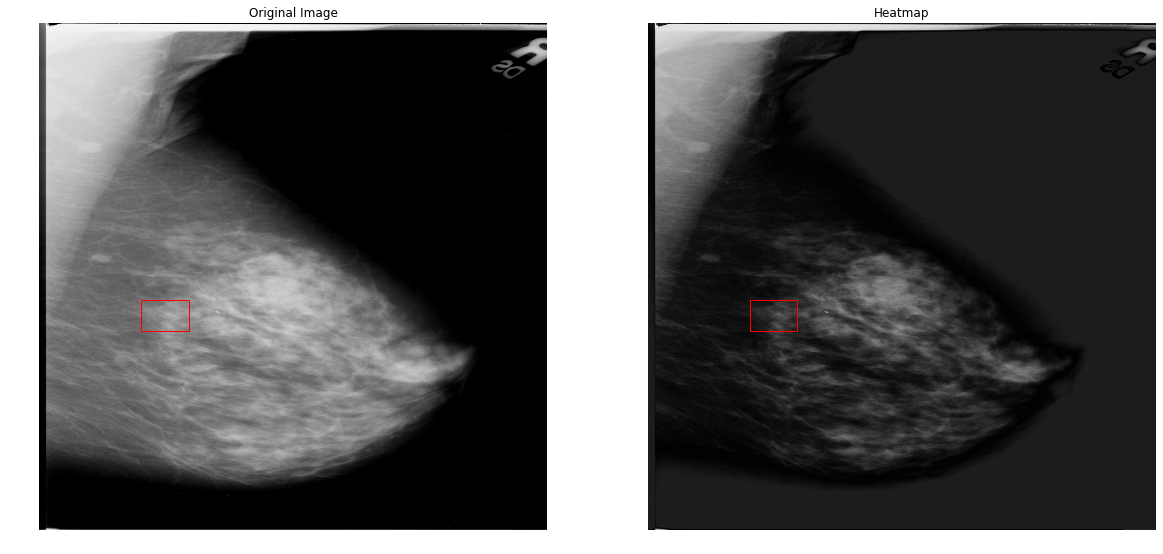

predicted Label Benign Mass
True Label Benign Calcification


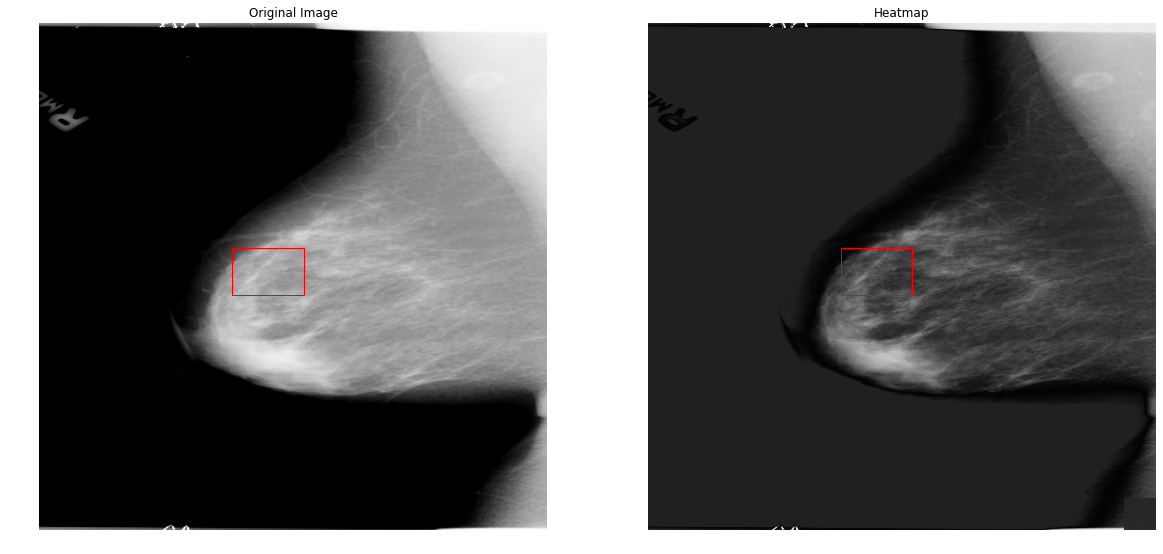

In [56]:
make_heatmap(inceptionNetParallel, dataloaders['test'], kernel_size=64, stride=64)

In [47]:
a = next(iter(dataloaders['test']))

In [52]:
a['img1'].squeeze()

tensor([[0.9192, 0.9165, 0.9199,  ..., 1.0000, 1.0000, 1.0000],
        [0.9202, 0.9189, 0.9172,  ..., 1.0000, 1.0000, 1.0000],
        [0.9192, 0.9185, 0.9165,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [0.0968, 0.1045, 0.0917,  ..., 1.0000, 1.0000, 1.0000],
        [0.0998, 0.0974, 0.0924,  ..., 1.0000, 1.0000, 1.0000],
        [0.0998, 0.1018, 0.0874,  ..., 1.0000, 1.0000, 1.0000]],
       dtype=torch.float64)